# Snippet

In [1]:
from zlib import crc32

import numpy as np


def split_check(
    unique_id: int or str, test_ratio: float, validation_ratio: float = 0
) -> str:
    if type(unique_id) is int:
        byteslike_identifier = np.int64(unique_id)
    else:
        byteslike_identifier = bytes(str(unique_id), "utf-8")

    hashed = crc32(byteslike_identifier) & 0xFFFFFFFF

    max_hash = 2 ** 32 - 1
    test_boundary = max_hash - max_hash * 0.2
    validation_boundary = test_boundary - max_hash * validation_ratio
    
    if hashed >= test_boundary:
        return "test"
    elif hashed < test_boundary and hashed >= validation_boundary:
        return "validation"
    else:
        return "training"

def add_split_column(data, id_column, test_ratio, **kwargs):
    split_assignment = data[id_column].apply(lambda x: split_check(x, test_ratio, kwargs["validation_ratio"]))
    return data.assign(split_assignment=split_assignment)

# Demo

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame({"id": range(1, 2000)})

In [3]:
df

,id
0,1
1,2
2,3
3,4
4,5
...,...
1994,1995
1995,1996
1996,1997
1997,1998


In [4]:
df_split = add_split_column(df, "id", 0.2, validation_ratio=0.2)

In [5]:
df_split

,id,split_assignment
0,1,validation
1,2,training
2,3,test
3,4,test
4,5,training
...,...,...
1994,1995,training
1995,1996,training
1996,1997,training
1997,1998,test


In [6]:
df_split["split_assignment"].value_counts()

training      1200
validation     401
test           398
Name: split_assignment, dtype: int64

Here I demonstrate the number of samples that land in a test set with a ratio of 0.2. As a rule of thumb, with 500 samples your test set will be between 15% and 25% of your data set. As the number of samples decreases, this increases and often falls between 17.5% and 22.5% of your data set.

In [7]:
v_split_check = np.vectorize(split_check)

def split_sample(sample_size, set_ratio):
    split = [split_check(np.random.randint(2**63), set_ratio) for _ in range(sample_size)]
    random_ids = np.random.randint(0, 2**63, sample_size)
    data_split = v_split_check(random_ids, set_ratio)
    return (data_split=="test").sum()

In [8]:
graph_df = pd.DataFrame({"sample_size": range(5, 5001, 5)})
graph_df = graph_df.assign(test_set_size=graph_df["sample_size"].apply(lambda x: split_sample(x, 0.2)))
graph_df = graph_df.assign(test_set_ratio=graph_df["test_set_size"]/graph_df["sample_size"])

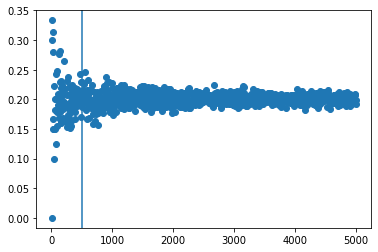

In [9]:
plt.scatter(graph_df["sample_size"], graph_df["test_set_ratio"])
plt.axvline(x=500)

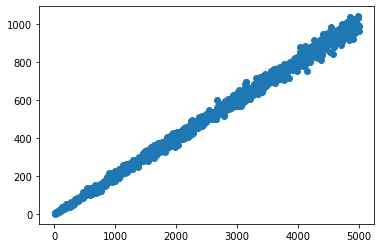

In [10]:
plt.scatter(graph_df["sample_size"], graph_df["test_set_size"])